In [ ]:
from __future__ import absolute_import, division, print_function

import sys
import logging
import math
import datetime
import random
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_privacy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow_privacy.privacy.analysis.rdp_accountant import (
    compute_rdp,
    get_privacy_spent,
)
from tensorflow_privacy.privacy.optimizers import dp_optimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

In [ ]:
df = pd.read_csv("student-mat.csv",sep=";")
#df_stud_por = pd.read_csv("student-por.csv",sep=";")

In [ ]:
pd.set_option('display.max_columns', 52)
df.select_dtypes(include='object')

In [ ]:
df_encode = pd.get_dummies(df)

In [ ]:
y=df_encode.G3
exclude_var=['G3']
print(exclude_var)
x_data=df_encode.drop(columns=exclude_var)

In [ ]:
y.value_counts()

In [ ]:
ybin = np.asarray(y)

In [ ]:
ybin[ybin<10] = 0

In [ ]:
ybin[ybin>=10] = 1

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# min-max normalization
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, ybin, test_size=0.2, random_state=0)

# get validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=0
)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
y_test

In [ ]:
y_train

In [ ]:
y_valid

In [ ]:
len(x.columns)

In [ ]:
training_size = x_train.shape[0]
training_size

In [ ]:
# from here https://github.com/VectorInstitute/PETs-Bootcamp/blob/main/DP_TensorFlowPrivacy/TFP_HeartDisease_KerasMLP_GridSearch.ipynb
def train(
    noise_multiplier,
    l2_norm_clip,
    batch_size,
    microbatches,
    x_train,
    y_train,
    dpsgd=True,
    learning_rate=0.1,
    epochs=120,
    model_dir=None,
    print_outputs=True,
    verbose=1,
):

    if dpsgd and batch_size % microbatches != 0:
        raise ValueError("Number of microbatches should divide evenly batch_size")

    # Define a sequential Keras model
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(40, input_dim=58, activation="relu"),
            tf.keras.layers.Dense(60, activation="relu"),
            tf.keras.layers.Dense(20, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    if dpsgd:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=microbatches,
            learning_rate=learning_rate,
        )
        # Compute vector of per-example loss rather than its mean over a minibatch.
        loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        loss = tf.keras.losses.BinaryCrossentropy()

    # Compile model with Keras
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, histogram_freq=1
    )

    # Train model with Keras
    model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_valid, y_valid),
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[tensorboard_callback],
    )

    score_train = model.evaluate(x_train, y_train, verbose=verbose)
    score_valid = model.evaluate(x_valid, y_valid, verbose=verbose)
    score_test = model.evaluate(x_test, y_test, verbose=verbose)

    weights = model.get_weights()

    # Compute the privacy budget expended.
    # // is integer division
    if dpsgd:
        eps = compute_epsilon(
            epochs * training_size // batch_size,
            training_size=training_size,
            noise_multiplier=noise_multiplier,
            batch_size=batch_size,
        )

    else:
        eps = "non-private SGD"

    if print_outputs:
        print(
            "\nhyperparamters: learning rate = "
            + str(learning_rate)
            + ", noise_multiplier = "
            + str(noise_multiplier)
            + ", l2_norm_clip = "
            + str(l2_norm_clip)
            + ", epochs = "
            + str(epochs)
            + ", batch_size = "
            + str(batch_size)
            + ", microbatches = "
            + str(microbatches)
        )

        print("  training loss: %.2f" % score_train[0])
        print("  training accuracy: %.2f" % score_train[1])

        print("  validation loss: %.2f" % score_valid[0])
        print("  validation accuracy: %.2f" % score_valid[1])

        print("  test loss: %.2f" % score_test[0])
        print("  test accuracy: %.2f" % score_test[1])
        
        Y_pred = model.predict(x_test)
        Y_pred = np.where(Y_pred > 0.5, 1,0)#np.argmax(Y_pred,axis=1)
        print(classification_report(y_test, Y_pred))   

        if dpsgd:
            print("For delta=0.00413223, the current epsilon is: %.2f" % eps)
        else:
            print("Trained with vanilla non-private SGD optimizer")

    return score_train, score_valid, score_test, eps, weights, Y_pred

In [ ]:
def compute_epsilon(steps, training_size, noise_multiplier, batch_size):
    """
    Computes epsilon value for given hyperparameters.

    Parameters required:
      steps: Number of steps the optimizer takes over the training data
             steps = FLAGS.epochs * training_size// FLAGS.batch_size

      Noise multiplier:
          the amount of noise sampled and added to gradients during training
    """
    if noise_multiplier == 0.0:
        return float("inf")

    """ 
  Delta: for (epsilon, delta)-DP
    Delta bounds the probability of our privacy guarantee not holding.  
    rule of thumb for delta is to set it to less than the inverse of the training data size
    so I opted for it to equal to 1.1*training size
  """
    training_delta = 1 / (training_size * 1.1)

    """
  We need to define a list of orders, at which the Rényi divergence will be computed
  if you want epsilon between 1-10 and your delta is fixed
  your orders must cover the range between 1+ln(1/delta)/10 and 1+ln(1/delta)/1 
  """
    orders = np.linspace(
        1 + math.log(1.0 / training_delta) / 10,
        1 + math.log(1.0 / training_delta) / 1,
        num=100,
    )

    """ 
  Sampling ratio q:
    the probability of an individual training point being included in a minibatch
    sampling_probability = FLAGS.batch_size / training_size
  """
    sampling_probability = batch_size / training_size

    """ 
  compute Renyi Differential Privacy, a generalization of pure differential privacy
  RDP is well suited to analyze DP guarantees provided by sampling followed by Gaussian noise addition, 
  which is how gradients are randomized in the TFP implementation of the DP-SGD optimizer.
  """
    rdp = compute_rdp(
        q=sampling_probability,
        noise_multiplier=noise_multiplier,
        steps=steps,
        orders=orders,
    )

    return get_privacy_spent(orders, rdp, target_delta=training_delta)[0]

## Train model

In [ ]:
training_outputs = train(
    noise_multiplier=1,
    l2_norm_clip=1,
    batch_size=22,
    microbatches=11,
    x_train=x_train,
    y_train=y_train,
    dpsgd=False,
    learning_rate=0.1,
    epochs=100,
    model_dir=None,
    print_outputs=True,
)

In [ ]:
# dpsgd model
training_outputs = train(
    noise_multiplier=1,
    l2_norm_clip=1,
    batch_size=22,
    microbatches=1,
    x_train=x_train,
    y_train=y_train,
    dpsgd=True,
    learning_rate=0.1,
    epochs=100,
    model_dir=None,
    print_outputs=True,
)

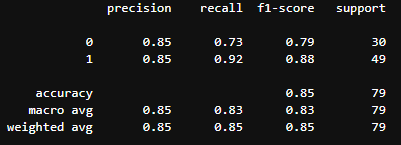
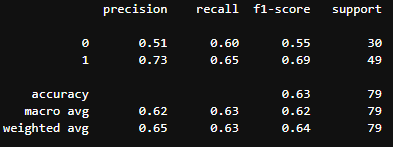

In [ ]:
def train_hp_tuning(
    noise_multipliers,
    l2_norm_clips,
    batch_sizes,
    microbatches,
    x_train,
    y_train,
    dpsgd=True,
    learning_rate=0.1,
    epochs=120,
    model_dir=None,
    print_outputs=False,
    verbose=0,
):

    table_outputs = []
    for batch_size in batch_sizes:
        if dpsgd and batch_size % microbatches != 0:
            raise ValueError("Number of microbatches should divide evenly batch_size")
        for l2_norm_clip in l2_norm_clips:
            for noise_multiplier in noise_multipliers:

                print(f"Batch Size: {batch_size}")
                print(f"L2 Norm Clip: {l2_norm_clip}")
                print(f"Noise Multiplier: {noise_multiplier}")

                try:

                    score_train, score_valid, score_test, eps, weights = train(
                        noise_multiplier,
                        l2_norm_clip,
                        batch_size,
                        microbatches,
                        x_train=x_train,
                        y_train=y_train,
                        dpsgd=True,
                        learning_rate=learning_rate,
                        epochs=epochs,
                        model_dir=model_dir,
                        print_outputs=print_outputs,
                        verbose=verbose,
                    )

                    table_outputs.append(
                        [
                            learning_rate,
                            noise_multiplier,
                            l2_norm_clip,
                            epochs,
                            batch_size,
                            microbatches,
                            score_train[0],
                            score_train[1],
                            score_valid[0],
                            score_valid[1],
                            score_test[0],
                            score_test[1],
                            eps,
                        ]
                    )
                    # print(table_outputs[-1])
                except Exception as e:
                    print(f"Configuration failed to train.")
                    print(f"Batch Size: {batch_size}")
                    print(f"L2 Norm Clip: {l2_norm_clip}")
                    print(f"Noise Multiplier: {noise_multiplier}")
                    print(e)

    df = pd.DataFrame(
        table_outputs,
        columns=[
            "learning rate",
            "noise multiplier",
            "L2 norm clip",
            "Epochs",
            "Batch size",
            "Microbatches",
            "Training loss",
            "Training accuracy",
            "Validation loss",
            "Validation accuracy",
            "Test loss",
            "Test accuracy",
            "Epsilon",
        ],
    )

    return df

In [ ]:
noise_multipliers = [1, 3, 5]
l2_norm_clips = [0.8, 1.0, 1.2]
batch_sizes = [11, 22, 242]

training_outputs = train_hp_tuning(
    noise_multipliers=noise_multipliers,
    l2_norm_clips=l2_norm_clips,
    batch_sizes=batch_sizes,
    microbatches=1,
    x_train=x_train,
    y_train=y_train,
    dpsgd=True,
    learning_rate=0.1,
    epochs=100,
    model_dir=None,
    print_outputs=False,
    verbose=0,
)

In [ ]:
training_outputs.sort_values(
    by=["Validation accuracy", "Epsilon"], ascending=[False, True]
)